[Metrics] Grid-MSE = 1.7204e-03 | Zero-TPR(in [0.3,0.6]) = 0.625 | Zero-FPR(outside) = 0.496 | alpha=0.600


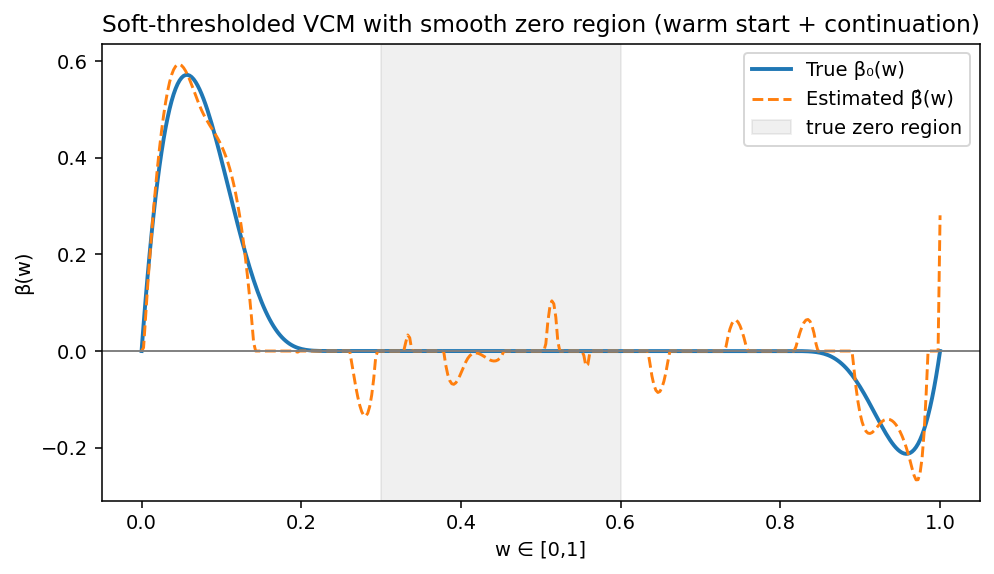

In [1]:
import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt

# ------------------------------
# 0) 真实函数：带严格零区间且 C∞ 光滑衔接
# ------------------------------
def ghost_mask(u, a=0.1, b=0.9):
    t = np.maximum(0.0, np.maximum(a - u, u - b))
    m = np.zeros_like(t, dtype=float)
    outside = t > 0
    m[outside] = np.exp(-1.0 / t[outside])  # C∞: 所有阶导在区间边界为 0
    return m

def beta_true_func(u):
    return np.sin(2*np.pi*u) * ghost_mask(u, a=0.3, b=0.75)*100

# ------------------------------
# 1) 数据生成
# ------------------------------
rng = np.random.default_rng(7)
n = 600
W = rng.uniform(0, 1, size=n)
X = rng.normal(0, 1, size=n)
sigma = 0.12
beta0 = beta_true_func(W)
Y = X * beta0 + rng.normal(0, sigma, size=n)

# ------------------------------
# 2) B 样条基
# ------------------------------
degree = 3
q = 30  # 基函数个数（可 CV 选；演示取固定值）

def uniform_open_knot_vector(q, degree):
    K = q - degree - 1
    start = np.zeros(degree+1); end = np.ones(degree+1)
    internal = np.array([]) if K <= 0 else np.linspace(0,1,K+2)[1:-1]
    return np.concatenate([start, internal, end])

kv = uniform_open_knot_vector(q, degree)

def bspline_basis_matrix(w, q, degree, kv):
    w = np.asarray(w); n_ = w.size
    # 初始（0 次）基
    N = np.zeros((n_, q))
    for j in range(q):
        N[:, j] = ((w >= kv[j]) & (w < kv[j+1])).astype(float)
    N[w == kv[-1], -1] = 1.0
    # Cox-de Boor 递推
    for p in range(1, degree+1):
        N_new = np.zeros_like(N)
        for j in range(q):
            denom1 = kv[j+p]-kv[j]
            term1 = 0.0 if denom1==0 else ((w-kv[j])/denom1)*N[:, j]
            if j+1 < q:
                denom2 = kv[j+p+1]-kv[j+1]
                term2 = 0.0 if denom2==0 else ((kv[j+p+1]-w)/denom2)*N[:, j+1]
            else:
                term2 = 0.0
            N_new[:, j] = term1 + term2
        N = N_new
    return N

B = bspline_basis_matrix(W, q, degree, kv)        # n x q
w_grid = np.linspace(0, 1, 400)
B_grid = bspline_basis_matrix(w_grid, q, degree, kv)

# ------------------------------
# 3) 论文核心算子：ζ 及其可微近似 H_eta（式(2)(4)）
# ------------------------------
def zeta(theta, alpha):
    return np.where(theta > alpha, theta - alpha,
                    np.where(theta < -alpha, theta + alpha, 0.0))

def H_smooth(theta, alpha, eta):
    u = (theta - alpha)/eta
    v = (theta + alpha)/eta
    # 式(4) arctan 平滑
    return 0.5 * ( (1 + (2/np.pi)*np.arctan(u))*(theta - alpha)
                 + (1 - (2/np.pi)*np.arctan(v))*(theta + alpha) )

def dH_dtheta(theta, alpha, eta):
    u = (theta - alpha)/eta
    v = (theta + alpha)/eta
    dA = (2/np.pi) * (1/(1+u*u)) * (1/eta)
    dB = (2/np.pi) * (1/(1+v*v)) * (1/eta)
    A = np.arctan(u); Bv = np.arctan(v)
    term1 = 0.5 * (1 + (2/np.pi)*A + dA*(theta - alpha))
    term2 = 0.5 * (1 - (2/np.pi)*Bv - dB*(theta + alpha))
    return term1 + term2

# ------------------------------
# 4) 阈值 α 的设定（论文 2.5 建议：半个尺度）
# ------------------------------
b1 = np.sum(X*Y) / max(1e-12, np.sum(X**2))   # OLS 斜率
alpha_target = float(np.clip(0.5 * abs(b1), 0.6, 0.8))

# ------------------------------
# 5) Warm Start：先估 β(w)，再构造 θ_init(w)
#    5.1 线性 B 样条回归：Y ≈ (X⊙B)·γβ
# ------------------------------
Z = (X[:, None]) * B     # n x q 设计矩阵
ridge = 1e-6
gamma_beta = LA.solve(Z.T@Z + ridge*np.eye(q), Z.T@Y)
beta_init_vals = B@gamma_beta           # 估计 β(w_i)
# 5.2 构造 θ_init(w) = β_init(w) + α·sign(β_init(w))
theta_init_vals = beta_init_vals + alpha_target * np.sign(beta_init_vals)
# 5.3 最小二乘把 θ_init(w_i) 投影回 Bγ
gamma0 = LA.solve(B.T@B + 1e-8*np.eye(q), B.T@theta_init_vals)

# ------------------------------
# 6) 同伦（η 由大到小），每阶段做若干步梯度下降
# ------------------------------
def fit_gamma_with_continuation(B, X, Y, gamma_init, alpha, etas,
                                rho, iters_per=400, lr=0.2, decay_every=150, decay=0.7):
    n, q = B.shape
    gamma = gamma_init.copy()
    for eta in etas:
        lr_i = lr
        for t in range(iters_per):
            theta = B @ gamma
            h = H_smooth(theta, alpha, eta)
            resid = Y - X*h
            dH = dH_dtheta(theta, alpha, eta)
            grad_data = -(2.0/n) * (B * (resid * X * dH)[:, None]).sum(axis=0)
            grad_pen  = (2.0/n) * (B * theta[:, None]).sum(axis=0) * rho
            gamma -= lr_i * (grad_data + grad_pen)
            if (t+1) % decay_every == 0:
                lr_i *= decay
    return gamma

rho = 1.0/(n**2)  # 论文建议
etas = [0.10, 0.03, 0.01]   # 同伦：先“软”，再“硬”
gamma_hat = fit_gamma_with_continuation(B, X, Y, gamma0, alpha_target,
                                        etas, rho, iters_per=400, lr=0.25)

# ------------------------------
# 7) 恢复 β̂(w) 并评估
# ------------------------------
theta_grid = B_grid @ gamma_hat
beta_hat_grid = zeta(theta_grid, alpha_target)

beta_true_grid = beta_true_func(w_grid)
mse = np.mean((beta_hat_grid - beta_true_grid)**2)
zero_region = (w_grid >= 0.3) & (w_grid <= 0.6)
zero_FPR = np.mean(np.abs(beta_hat_grid[~zero_region]) < 1e-3)  # 非零区误报为零的比例
zero_TPR = np.mean(np.abs(beta_hat_grid[zero_region]) < 1e-3)   # 零区识别率

print(f"[Metrics] Grid-MSE = {mse:.4e} | Zero-TPR(in [0.3,0.6]) = {zero_TPR:.3f} | "
      f"Zero-FPR(outside) = {zero_FPR:.3f} | alpha={alpha_target:.3f}")

# ------------------------------
# 8) 可视化
# ------------------------------
plt.figure(figsize=(7.2,4.2), dpi=140)
plt.plot(w_grid, beta_true_grid, label="True β₀(w)", linewidth=2)
plt.plot(w_grid, beta_hat_grid, label="Estimated β̂(w)", linestyle="--")
plt.axvspan(0.3, 0.6, color='k', alpha=0.06, label="true zero region")
plt.axhline(0, color='gray', linewidth=1)
plt.title("Soft-thresholded VCM with smooth zero region (warm start + continuation)")
plt.xlabel("w ∈ [0,1]"); plt.ylabel("β(w)")
plt.legend(); plt.tight_layout(); plt.show()
